In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from google.colab import files
%matplotlib inline

80134624/80134624 [==============================] - 3s 0us/step


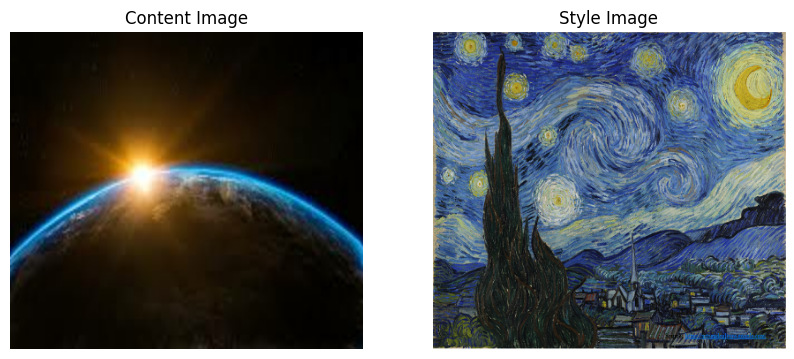

In [2]:
# Load pre-trained VGG-19 model
vgg = tf.keras.applications.VGG19(include_top=False,input_shape=(360, 400, 3), weights='imagenet')

# Content image path
content_path = '/content/content.jpeg'
# Style image path
style_path = '/content/style.png'
# Load and preprocess images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image[tf.newaxis, :]
    image = tf.image.resize(image, (360, 400))  # Resize to match VGG input size
    return image

content_image = load_image(content_path)
style_image = load_image(style_path)

# Display the images
def plot_images(content, style):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(content[0])
    axes[0].set_title('Content Image')
    axes[0].axis('off')
    axes[1].imshow(style[0])
    axes[1].set_title('Style Image')
    axes[1].axis('off')
    plt.show()

plot_images(content_image, style_image)

# Define content, style, and total variation loss functions
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])

    # compute the cost with tensorflow (≈1 line)
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    return J_content

def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

def compute_layer_style_cost(a_S, a_G):
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    # OR a_S = tf.transpose(tf.reshape(a_S, shape=[ n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
    return J_style_layer


In [3]:
vgg.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 90, 100, 128)      0     

In [4]:
#Now choose layers to represent the style of the image and assign style costs:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The first element of the array contains the input layer image, which must not to be used.
    a_S = style_image_output[1:]

    # Set a_G to be the output of the choosen hidden layers.
    # The First element of the list contains the input layer image which must not to be used.
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

@tf.function()

def total_cost(J_content, J_style, alpha = 20, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


(1, 360, 400, 3)


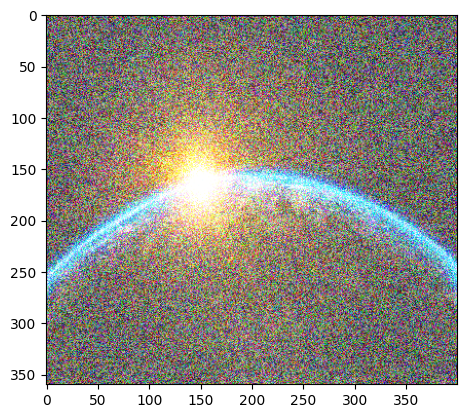

In [5]:
content_image = tf.Variable(content_image)
style_image = tf.Variable(style_image)
generated_image = tf.Variable(content_image.initialized_value())

noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [6]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # layer_names has 'layer' elements in it.
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

CONTENT_LAYER = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + CONTENT_LAYER)
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2']
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.008517561, shape=(), dtype=float32)


In [7]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(5985.949, shape=(), dtype=float32)


In [8]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image, alpha = 10, beta = 40):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)

        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style,alpha = alpha, beta = beta)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

In [10]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

epochs = 500
for i in range(epochs):
    train_step(generated_image,alpha = 100, beta = 10**2)
    if i % 50 == 0:
        print(f"Epoch {i} ")

Epoch 0 
Epoch 50 
Epoch 100 
Epoch 150 
Epoch 200 
Epoch 250 
Epoch 300 
Epoch 350 
Epoch 400 
Epoch 450 


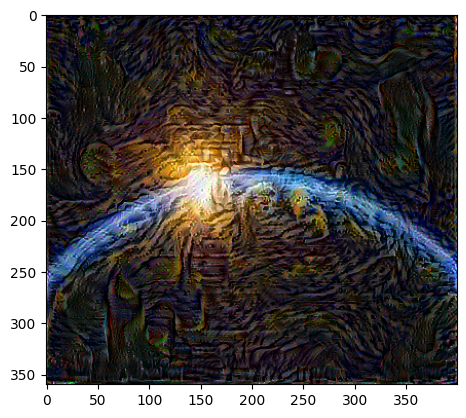

In [11]:
image = tensor_to_image(generated_image)
imshow(image)
image.save('/content/output.jpg')
plt.show()

In [12]:
import cv2
import os
import shutil

def extract_frames(video_path, output_dir, frame_rate):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Open video file
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames and frame rate
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate frame interval based on desired frame rate
    frame_interval = int(round(video_fps / frame_rate))

    # Iterate over frames
    frame_count = 0
    while True:
        # Read the next frame
        ret, frame = cap.read()

        # If frame cannot be read, exit the loop
        if not ret:
            break

        # Skip frames if needed
        if frame_count % frame_interval != 0:
            frame_count += 1
            continue
        if(frame_count<10):
          w='00'+str(frame_count)
        elif(frame_count<100):
          w='0'+str(frame_count)
        else:
          w=str(frame_count)
        # Save the frame as an image
        frame_filename = os.path.join(output_dir, f"frame_"+w+".jpg")
        cv2.imwrite(frame_filename, frame)

        frame_count += 1

    # Release the video capture object
    cap.release()

# Specify the path to the video file
video_path = '/content/video.mp4'

# Specify the output directory where frames will be saved
output_dir = '/content/frame'

# Specify the desired frame rate (frames per second)
frame_rate = 5  # For example, 5 frames per second

# Call the function to extract frames
extract_frames(video_path, output_dir, frame_rate)


In [13]:
for x in range(0,960,5):
  if(x<10):
    w='00'+str(x)
  elif(x<100):
    w='0'+str(x)
  else:
    w=str(x)
  content_image = load_image('/content/frame/frame_'+w+'.jpg')
  content_image = tf.Variable(content_image)
  generated_image = tf.Variable(content_image.initialized_value())
  content_target = vgg_model_outputs(content_image)  # Content encoder
  preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
  a_C = vgg_model_outputs(preprocessed_content)
  a_G = vgg_model_outputs(generated_image)

  # Compute the content cost
  J_content = compute_content_cost(a_C, a_G)

  generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
  epochs = 50
  for i in range(epochs):
      train_step(generated_image,alpha = 100, beta = 10**2)
  if(x%100==0):
    print('frame '+str(x))
  image = tensor_to_image(generated_image)
  frame_filename = os.path.join('/content/output_frame', f"out_frame_"+w+".jpg")
  image=np.array(image)
  cv2.imwrite(frame_filename, image)


frame 0
frame 100
frame 200
frame 300
frame 400
frame 500
frame 600
frame 700
frame 800
frame 900


In [14]:
def frames_to_video(frames_dir, output_path, frame_rate):
    frame_files = sorted(os.listdir(frames_dir))  # Get the list of frame files in the directory

    # Get the first frame to determine dimensions
    first_frame_path = os.path.join(frames_dir, frame_files[0])
    first_frame = cv2.imread(first_frame_path)
    height, width, _ = first_frame.shape

    # Define the video codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Use mp4v codec for MP4 format
    video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, (width, height))

    # Write each frame to the video
    for frame_file in frame_files:
        frame_path = os.path.join(frames_dir, frame_file)
        frame = cv2.imread(frame_path)
        video_writer.write(frame)

    # Release the video writer
    video_writer.release()
    print(f"Video saved at {output_path}")

frames_directory = '/content/output_frame'
output_video_path = '/content/output_video.mp4'
frame_rate = 10  # Desired frame rate for the video (frames per second)
frames_to_video(frames_directory, output_video_path, frame_rate)

Video saved at /content/output_video.mp4


In [15]:
def download_folder(folder_path):
    shutil.make_archive(folder_path, 'zip', folder_path)
    files.download(folder_path)

download_folder('/content/frame')
download_folder('/content/output_frame')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>